In [119]:
import json
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split, Subset, SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torchtext.vocab import GloVe
import tqdm

# Task 2

## Preprocessing

In [120]:
with open('Laptop_Review_Train.json') as f:
    train_data = json.load(f)

In [121]:
with open('Laptop_Review_Val.json') as f:
    val_data = json.load(f)

In [122]:
with open('Laptop_Review_Test.json') as f:
    test_data = json.load(f)

In [123]:
def bio_label_encoding(tokens, aspects):
    labels = ['O'] * len(tokens)
    for aspect in aspects: 
        start = aspect['from']
        end = aspect['to']
        labels[start] = 'B'
        for i in range(start+1, end):
            labels[i] = 'I'
    return labels

In [124]:
def convert_to_bio(data):
    processed_data = {}
    for i in range(len(data)):
        words = data[i]['words']
        text = data[i]['raw_words']
        aspects = data[i]['aspects']
        labels = bio_label_encoding(words, aspects)
        processed_data[i] = {
            'text': text,
            'labels': labels
        }
    return processed_data

In [125]:
processed_train_data = convert_to_bio(train_data)
processed_val_data = convert_to_bio(val_data)
processed_test_data = convert_to_bio(test_data)

In [126]:
# dumping the processed data
with open('ATE_train.json', 'w') as f:
    json.dump(processed_train_data, f, indent=4)
with open('ATE_val.json', 'w') as f:
    json.dump(processed_val_data, f, indent=4)
with open('ATE_test.json', 'w') as f:
    json.dump(processed_test_data, f, indent=4) 

In [127]:
with open('ATE_train.json') as f:
    train_data = json.load(f)
with open('ATE_val.json') as f:
    val_data = json.load(f)
with open('ATE_test.json') as f:
    test_data = json.load(f)

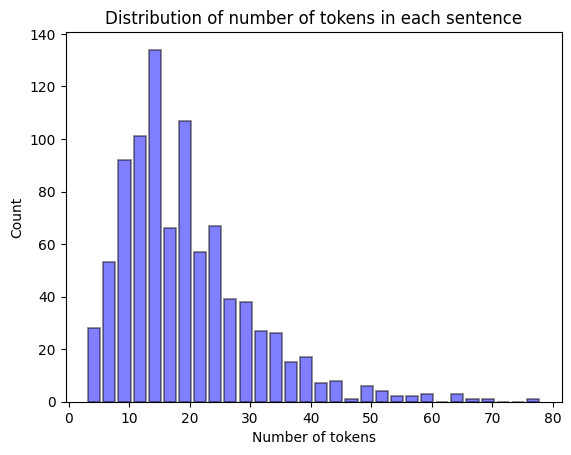

In [128]:
# plotting data distribution of number of tokens in each sentence
import matplotlib.pyplot as plt
label_counts = []
for key in train_data.keys():
    label_counts.append(len(train_data[key]['labels']))
plt.hist(label_counts, bins=30, alpha=0.5, color='b', edgecolor='black', linewidth=1.2, histtype='bar', align='mid', orientation='vertical', rwidth=0.8, label='Number of tokens')
plt.title('Distribution of number of tokens in each sentence')
plt.xlabel('Number of tokens')
plt.ylabel('Count')
plt.show()

In [60]:
train, val, test = [], [], []
for i in train_data:
    train.append([train_data[i]['text'], train_data[i]['labels']])
for i in val_data:
    val.append([val_data[i]['text'], val_data[i]['labels']])
for i in test_data:
    test.append([test_data[i]['text'], test_data[i]['labels']])

In [61]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 3495
Words and their counts: [('I', 637), ('charge', 10), ('it', 499), ('at', 70), ('night', 5)]


In [62]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 3497


In [63]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
label_to_idx = {'O': 0, 'B': 1, 'I': 2}
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")

Word-to-index: [('I', 0), ('charge', 1), ('it', 2), ('at', 3), ('night', 4)]
Index-to-word: [(0, 'I'), (1, 'charge'), (2, 'it'), (3, 'at'), (4, 'night')]


### Initializing the glove vectors

In [64]:
glove_vectors = GloVe(name='6B', dim=300)
word_embeddings = np.zeros((len(word_list), 300))
for i in range(len(word_list)):
    word = word_list[i]
    idx = word_to_index[word]
    if word in glove_vectors.stoi:
        word_embeddings[idx] = glove_vectors[word]
    else:
        word_embeddings[idx] = glove_vectors['unk']
print(f"Shape of word_embeddings: {word_embeddings.shape}")

Shape of word_embeddings: (3497, 300)


In [65]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (3497, 300)


In [66]:
def collate_fn(batch):
    """
        Padding the sequences to the maximum length sequence in the batch
        Args:
            batch: list of individual elements of the dataset
        Returns:
            {'text' : padded_texts, 'labels' : padded_labels}
    """
    texts, labels = [item['text'] for item in batch], [item['labels'] for item in batch]
    max_len = max([len(text) for text in texts])
    padded_texts, padded_labels = [], []
    for i in range(len(texts)):
        text, label = texts[i], labels[i]
        # padding text and label sequences
        text = text + [word_to_index['PAD']] * (max_len - len(text))
        label = label + [label_to_idx['O']] * (max_len - len(label))
        padded_texts.append(text)
        padded_labels.append(label)
    return {'text': torch.tensor(padded_texts), 'labels': torch.tensor(padded_labels)}

In [67]:
class LaptopReviewDataset(Dataset):
    """
        Custom Dataset to load the Laptop Review dataset
        Args:
            data: list of tuples (text, labels)
            vocab_size: size of the vocabulary
            embedding_size: size of the word embeddings
            word_to_index: word-to-index mapping
            index_to_word: index-to-word mapping
            label_to_idx: label-to-index mapping
    """
    def __init__(self, data, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx):
        self.data = data
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.word_to_index = word_to_index
        self.index_to_word = index_to_word
        self.label_to_idx = label_to_idx 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text, labels = self.data[idx][0], self.data[idx][1]
        words = text.split()
        # converting words and labels to indices
        word_indices = [self.word_to_index[word] if word in self.word_to_index else self.word_to_index['UNK'] for word in words]
        label_indices = [self.label_to_idx[label] for label in labels]
        sample = {'text' : word_indices, 'labels' : label_indices}
        return sample

In [68]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [69]:
test_dataset = LaptopReviewDataset(test, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)

In [70]:
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [71]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            text, labels = data['text'], data['labels']
            output, hidden = model(text)
            output = output.view(-1, 3)
            labels = labels.view(-1)
            loss += criterion(output, labels).item()
            y_true += labels.tolist()
            y_pred += torch.argmax(output, 1).tolist()
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, macro_f1, loss

In [72]:
def evaluation(model, dataloader, criterion):
    model.eval()
    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            text, labels = data['text'], data['labels']
            outputs, hidden = model(text)
            outputs = outputs.view(-1, 3)
            labels = labels.view(-1)
            loss += criterion(outputs, labels).item()
            y_true += labels.tolist()
            y_pred += torch.argmax(outputs, 1).tolist()
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    precision = precision_score(y_true, y_pred, average='weighted')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    from sklearn.metrics import classification_report
    classification_report = classification_report(y_true, y_pred)
    return accuracy, precision, macro_f1, loss, classification_report

In [161]:
criterion = nn.CrossEntropyLoss()

In [74]:
class RNNModel(nn.Module):
    """
        Model architecture to perform Sequence Labeling on the Laptop Review dataset. RNN, LSTM or GRU model is initialized based on the model configuration parameters.
        Args: 
            vocab_size: size of the vocabulary
            embed_size: size of the word embeddings
            hidden_size: size of the hidden state
            pretrained_embeddings: pre-trained word embeddings
            model_config: dictionary containing model configuration parameters
    """
    def __init__(self, vocab_size, embed_size, hidden_size, pretrained_embeddings, model_config):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings=pretrained_embeddings, freeze=True)
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], nonlinearity=model_config['activation'], batch_first=True, dropout=model_config['dropout'])
        if (model_config['model'] == 'LSTM'):
            self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], batch_first=True, dropout=model_config['dropout'])
        if (model_config['model'] == 'GRU'):
            self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], batch_first=True, dropout=model_config['dropout'])
        self.fc = nn.Linear(hidden_size, 3)
        
    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        output = self.fc(output)
        return output, hidden

In [75]:
model_config = dict(
    task = 2, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

#### RNN + GloVe for Task 2

In [76]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 2\GloVe\\t2_model1_glove.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\2112311114.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 2\GloVe\\t2_model1_glove.pth"


Test accuracy: 0.9653
Test precision: 0.9603
Test macro F1: 0.6546
Test loss: 2.5851

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.65      0.49      0.56       463
           2       0.63      0.32      0.42       243

    accuracy                           0.97     15480
   macro avg       0.75      0.60      0.65     15480
weighted avg       0.96      0.97      0.96     15480



#### LSTM + GloVe for Task 2

In [77]:
model_config = dict(
    task = 2, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

C:\Users\saras\AppData\Local\Temp\ipykernel_3120\531312971.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [78]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 2\GloVe\\t2_model2_glove.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\3100204358.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 2\GloVe\\t2_model2_glove.pth"


Test accuracy: 0.9651
Test precision: 0.9609
Test macro F1: 0.6636
Test loss: 2.5930

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.62      0.52      0.57       463
           2       0.65      0.33      0.44       243

    accuracy                           0.97     15480
   macro avg       0.75      0.61      0.66     15480
weighted avg       0.96      0.97      0.96     15480



#### GRU + GloVe for Task 2

In [79]:
model_config = dict(
    task = 2, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

C:\Users\saras\AppData\Local\Temp\ipykernel_3120\1939184259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [80]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 2\GloVe\\t2_model3_glove.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\3727799638.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 2\GloVe\\t2_model3_glove.pth"


Test accuracy: 0.9691
Test precision: 0.9649
Test macro F1: 0.6841
Test loss: 2.2265

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14774
           1       0.70      0.52      0.60       463
           2       0.72      0.35      0.47       243

    accuracy                           0.97     15480
   macro avg       0.80      0.62      0.68     15480
weighted avg       0.96      0.97      0.97     15480



#### Task 2: RNN + Word2Vec

In [81]:
train, val, test = [], [], []
for i in train_data:
    train.append([train_data[i]['text'], train_data[i]['labels']])
for i in val_data:
    val.append([val_data[i]['text'], val_data[i]['labels']])
for i in test_data:
    test.append([test_data[i]['text'], test_data[i]['labels']])

In [82]:
print(f'Training data size: {len(train)}')
print(f'Validation data size: {len(val)}')
print(f'Test data size: {len(test)}')

Training data size: 906
Validation data size: 219
Test data size: 328


In [83]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 3495
Words and their counts: [('I', 637), ('charge', 10), ('it', 499), ('at', 70), ('night', 5)]


In [84]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 3497


In [85]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
label_to_idx = {'O': 0, 'B': 1, 'I': 2}
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")

Word-to-index: [('I', 0), ('charge', 1), ('it', 2), ('at', 3), ('night', 4)]
Index-to-word: [(0, 'I'), (1, 'charge'), (2, 'it'), (3, 'at'), (4, 'night')]


In [86]:
import gensim
import torch
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

# Load word embeddings
word_embeddings = []
for word in word_list:
    try:
        word_embeddings.append(wv[word])
    except:
        word_embeddings.append(wv['unk'])
word_embeddings = np.array(word_embeddings)
print(f"Shape of word embeddings: {word_embeddings.shape}")


Shape of word embeddings: (3497, 300)


In [87]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (3497, 300)


In [88]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [89]:
model_config = dict(
    task = 2, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [90]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)

3497 3497 300 128


In [93]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 2\Word2vec\\t2_model1_word2vec.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

Test accuracy: 0.9661
Test precision: 0.9633
Test macro F1: 0.6907
Test loss: 2.8735

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.62      0.58      0.60       463
           2       0.64      0.39      0.49       243

    accuracy                           0.97     15480
   macro avg       0.75      0.65      0.69     15480
weighted avg       0.96      0.97      0.96     15480



<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\2393678249.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 2\Word2vec\\t2_model1_word2vec.pth"


#### Task 2: GRU + Word2Vec

In [94]:
model_config = dict(
    task = 2, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [96]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 2\Word2vec\\t2_model3_word2vec.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\3104698454.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 2\Word2vec\\t2_model3_word2vec.pth"


Test accuracy: 0.9705
Test precision: 0.9680
Test macro F1: 0.7259
Test loss: 2.6822

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14774
           1       0.70      0.64      0.67       463
           2       0.69      0.42      0.53       243

    accuracy                           0.97     15480
   macro avg       0.79      0.68      0.73     15480
weighted avg       0.97      0.97      0.97     15480



### Task 2: LSTM + Word2Vec

In [97]:
model_config = dict(
    task = 2, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [98]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 2\Word2vec\\t2_model2_word2vec.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

Test accuracy: 0.9702
Test precision: 0.9681
Test macro F1: 0.7210
Test loss: 2.3645

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     14774
           1       0.67      0.65      0.66       463
           2       0.71      0.40      0.51       243

    accuracy                           0.97     15480
   macro avg       0.79      0.68      0.72     15480
weighted avg       0.97      0.97      0.97     15480



<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\1822750133.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 2\Word2vec\\t2_model2_word2vec.pth"


#### Task 2: RNN + FastText

In [99]:
from torchtext.vocab import FastText
fasttext_vectors = FastText(language="en")
word_embeddings = np.zeros((len(word_list), 300))
for i in range(len(word_list)):
    word = word_list[i]
    idx = word_to_index[word]
    if word in glove_vectors.stoi:
        word_embeddings[idx] = fasttext_vectors[word]
    else:
        word_embeddings[idx] = fasttext_vectors['unk']
print(f"Shape of word_embeddings: {word_embeddings.shape}")

.vector_cache\wiki.en.vec: 6.60GB [10:09, 10.8MB/s]                               
100%|██████████| 2519370/2519370 [06:38<00:00, 6315.62it/s] 


Shape of word_embeddings: (3497, 300)


In [104]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (3497, 300)


In [105]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [106]:
test_dataset = LaptopReviewDataset(test, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)

In [107]:
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [108]:
model_config = dict(
    task = 2, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [109]:
# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)

3497 3497 300 128


In [112]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 2\Fasttext\\t2_model1_fasttext.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

Test accuracy: 0.9640
Test precision: 0.9585
Test macro F1: 0.6402
Test loss: 2.4762

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14774
           1       0.63      0.48      0.54       463
           2       0.58      0.30      0.40       243

    accuracy                           0.96     15480
   macro avg       0.73      0.59      0.64     15480
weighted avg       0.96      0.96      0.96     15480



<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\2128703935.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 2\Fasttext\\t2_model1_fasttext.pth"


In [113]:
model_config = dict(
    task = 2, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [114]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 2\Fasttext\\t2_model3_fasttext.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\2677083102.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 2\Fasttext\\t2_model3_fasttext.pth"


Test accuracy: 0.9686
Test precision: 0.9650
Test macro F1: 0.6925
Test loss: 2.3416

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.67      0.56      0.61       463
           2       0.71      0.37      0.48       243

    accuracy                           0.97     15480
   macro avg       0.79      0.64      0.69     15480
weighted avg       0.97      0.97      0.97     15480



#### Task 2: LSTM + FastText

In [115]:
model_config = dict(
    task = 2, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [116]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 2\Fasttext\\t2_model2_fasttext.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\3628936752.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 2\Fasttext\\t2_model2_fasttext.pth"


Test accuracy: 0.9670
Test precision: 0.9625
Test macro F1: 0.6696
Test loss: 2.5365

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.67      0.53      0.59       463
           2       0.64      0.33      0.43       243

    accuracy                           0.97     15480
   macro avg       0.76      0.62      0.67     15480
weighted avg       0.96      0.97      0.96     15480



#### Task 2: GRU + FastText 

In [117]:
model_config = dict(
    task = 2, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [118]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 2\Fasttext\\t2_model3_fasttext.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\2677083102.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 2\Fasttext\\t2_model3_fasttext.pth"


Test accuracy: 0.9686
Test precision: 0.9650
Test macro F1: 0.6925
Test loss: 2.3416

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14774
           1       0.67      0.56      0.61       463
           2       0.71      0.37      0.48       243

    accuracy                           0.97     15480
   macro avg       0.79      0.64      0.69     15480
weighted avg       0.97      0.97      0.97     15480



# Task 1

In [129]:
with open('NER_TRAIN_JUDGEMENT.json') as file:
    data = json.load(file)

In [130]:
with open('NER_TEST_JUDGEMENT.json') as file:
    test_data = json.load(file)

In [131]:
train, val = train_test_split(data, test_size=0.15, random_state=42)

In [132]:
unique_labels = set()
for i in range(len(data)):
    for annotation in data[i]['annotations'][0]['result']:
        label = annotation['value']['labels'][0]
        unique_labels.add(label)
print(unique_labels)

{'ORG', 'JUDGE', 'STATUTE', 'WITNESS', 'COURT', 'PETITIONER', 'CASE_NUMBER', 'DATE', 'GPE', 'RESPONDENT', 'PRECEDENT', 'OTHER_PERSON', 'PROVISION'}


In [133]:
def clean_text(text):
    special_chars = ['\x05', '\t', '\n', '\x0c', '\x11', '\x12', '\x13', '\x14', '\x16', '\x1a', '\x80', '\x9d', '\xa0', '\xad', '\uf076']
    for char in special_chars:
        text = text.replace(char, ' ')
    return text

In [134]:
def border_index(annotations):
    border_indices = []
    for annotation in annotations[0]['result']:
        start = annotation['value']['start']
        end = annotation['value']['end']
        label = annotation['value']['labels'][0]
        label = label.upper()
        border_indices.append([start, end, label])
    border_indices.sort(key=lambda x: x[0])
    return border_indices

In [135]:
def border_spacing(text, border_indices):
    i = 0
    while i < len(text):
        for border in border_indices:
            if (i==border[0] or i==border[1]):
                index = border_indices.index(border)
                if (i==border[0] and i!=0 and text[i-1]!=' '):
                    text = text[:i] + ' ' + text[i:]
                    for j in range(index, len(border_indices)):
                        if border_indices[j][0] >= i:
                            border_indices[j][0] += 1
                        if border_indices[j][1] >= i:
                            border_indices[j][1] += 1
                if (i==border[1] and i!=len(text)-1 and text[i]!=' '):
                    text = text[:i] + ' ' + text[i:]
                    for j in range(index, len(border_indices)):
                        if border_indices[j][0] >= i:
                            border_indices[j][0] += 1
                        if border_indices[j][1] >= i:
                            border_indices[j][1] += 1
                i += 1
        i += 1
    return text, border_indices

In [136]:
def bio_encoding(text, border_indices):
    tokens = text.split()
    labels = ['O'] * len(tokens)
    for annotation in border_indices:
        start = annotation[0]
        end = annotation[1]
        label = annotation[2]
        label = label.upper()
        label_start_token = None
        label_end_token = None
        curr_token_index = 0
        i = 0
        while (i < len(text)):
            if (text[i] == ' '):
                i += 1
            else:
                curr_word = ''
                if (i == start):
                    label_start_token = curr_token_index
                    while (i < end):
                        current_word = ''
                        if (text[i] == ' '):
                            while (text[i] == ' '):
                                i += 1
                        else: 
                            while (i < len(text) and text[i] != ' '):
                                current_word += text[i]
                                i += 1
                            if (tokens[curr_token_index] == current_word):
                                curr_token_index += 1
                    label_end_token = curr_token_index
                else: 
                    while (i < len(text) and text[i] != ' '):
                        curr_word += text[i]
                        i += 1
                    if (tokens[curr_token_index] == curr_word):
                        curr_token_index += 1
        if (label_end_token == None):
            label_end_token = len(tokens) - 1
        if (label_start_token == None):
            continue
        for i in range(label_start_token, label_end_token):
            if i == label_start_token:
                labels[i] = 'B_' + label
            else:
                labels[i] = 'I_' + label
    return labels

In [137]:
def convert_to_bio(data):
    processed_data = {}
    for i in range(len(data)):
        id = data[i]['id']
        annotations = data[i]['annotations']
        text = data[i]['data']['text']
        text = clean_text(text)
        border_indices = border_index(annotations)
        text, border_indices = border_spacing(text, border_indices)
        labels = bio_encoding(text, border_indices)
        processed_data[id] = {'text': text, 'labels': labels}
    return processed_data

In [138]:
processed_train = convert_to_bio(train)
processed_val = convert_to_bio(val)
processed_test = convert_to_bio(test_data)

In [139]:
# dumping the processed data
with open('NER_train.json', 'w') as file:
    json.dump(processed_train, file, indent=4)
with open('NER_val.json', 'w') as file:
    json.dump(processed_val, file, indent=4)
with open('NER_test.json', 'w') as file:
    json.dump(processed_test, file, indent=4)

In [140]:
with open('NER_train.json') as file:
    train_data = json.load(file)
with open('NER_val.json') as file:
    val_data = json.load(file)
with open('NER_test.json') as file:
    test_data = json.load(file)

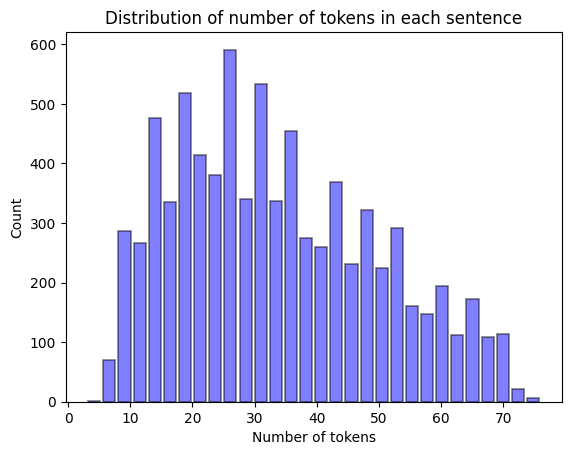

In [141]:
# plotting data distribution of number of tokens in each sentence
import matplotlib.pyplot as plt
label_counts = []
for key in train_data.keys():
    label_counts.append(len(train_data[key]['labels']))
plt.hist(label_counts, bins=30, alpha=0.5, color='b', edgecolor='black', linewidth=1.2, histtype='bar', align='mid', orientation='vertical', rwidth=0.8, label='Number of tokens')
plt.title('Distribution of number of tokens in each sentence')
plt.xlabel('Number of tokens')
plt.ylabel('Count')
plt.show()

In [143]:
train, val, test = [], [], []
for i in train_data:
    train.append([train_data[i]['text'], train_data[i]['labels']])
for i in val_data:
    val.append([val_data[i]['text'], val_data[i]['labels']])
for i in test_data:
    test.append([test_data[i]['text'], test_data[i]['labels']])

In [144]:
print(f'Training data size: {len(train)}')
print(f'Validation data size: {len(val)}')
print(f'Test data size: {len(test)}')

Training data size: 8019
Validation data size: 1416
Test data size: 949


In [145]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 37866
Words and their counts: [('Therefore,', 97), ('while', 164), ('interpreting', 6), ('statutory', 76), ('provisions,', 10)]


In [146]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 37868


In [147]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")

Word-to-index: [('Therefore,', 0), ('while', 1), ('interpreting', 2), ('statutory', 3), ('provisions,', 4)]
Index-to-word: [(0, 'Therefore,'), (1, 'while'), (2, 'interpreting'), (3, 'statutory'), (4, 'provisions,')]


In [148]:
# finding all the unique labels in the dataset
label_count = {}
for i in range(len(data)):
    labels = data[i][1]
    for label in labels:
        if label not in label_count:
            label_count[label] = 1
        else:
            label_count[label] += 1
print(f"Number of unique labels in the dataset: {len(label_count)}")
print(f"Labels and their counts: {list(label_count.items())}")
print(f"Labels and their counts: {list(label_count.items())}")
label_to_idx = {label:idx for idx, label in enumerate(label_count.keys())}
idx_to_label = {idx:label for label, idx in label_to_idx.items()}
print(f"Label-to-index: {list(label_to_idx.items())}")
print(f"Index-to-label: {list(idx_to_label.items())}")

Number of unique labels in the dataset: 27
Labels and their counts: [('O', 294339), ('B_CASE_NUMBER', 1161), ('I_CASE_NUMBER', 3975), ('B_ORG', 1600), ('I_ORG', 2945), ('B_OTHER_PERSON', 2929), ('I_OTHER_PERSON', 2252), ('B_STATUTE', 2026), ('I_STATUTE', 3659), ('B_PROVISION', 2642), ('I_PROVISION', 4326), ('B_COURT', 1471), ('I_COURT', 2854), ('B_WITNESS', 939), ('B_PRECEDENT', 1528), ('I_PRECEDENT', 13435), ('B_DATE', 2106), ('B_PETITIONER', 473), ('I_PETITIONER', 384), ('I_WITNESS', 810), ('B_GPE', 1581), ('B_RESPONDENT', 329), ('I_RESPONDENT', 448), ('I_DATE', 1480), ('B_JUDGE', 575), ('I_JUDGE', 398), ('I_GPE', 327)]
Labels and their counts: [('O', 294339), ('B_CASE_NUMBER', 1161), ('I_CASE_NUMBER', 3975), ('B_ORG', 1600), ('I_ORG', 2945), ('B_OTHER_PERSON', 2929), ('I_OTHER_PERSON', 2252), ('B_STATUTE', 2026), ('I_STATUTE', 3659), ('B_PROVISION', 2642), ('I_PROVISION', 4326), ('B_COURT', 1471), ('I_COURT', 2854), ('B_WITNESS', 939), ('B_PRECEDENT', 1528), ('I_PRECEDENT', 13435), 

In [149]:
from torchtext.vocab import GloVe
glove_vectors = GloVe(name='6B', dim=300)
word_embeddings = np.zeros((len(word_list), 300))
for i in range(len(word_list)):
    word = word_list[i]
    idx = word_to_index[word]
    if word in glove_vectors.stoi:
        word_embeddings[idx] = glove_vectors[word]
    else:
        word_embeddings[idx] = glove_vectors['unk']
print(f"Shape of word_embeddings: {word_embeddings.shape}")

Shape of word_embeddings: (37868, 300)


In [150]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (37868, 300)


In [151]:
def collate_fn(batch):
    """
        Padding the sequences to the maximum length sequence in the batch
        Args:
            batch: list of individual elements of the dataset
        Returns:
            {'text' : padded_texts, 'labels' : padded_labels}
    """
    texts, labels = [item['text'] for item in batch], [item['labels'] for item in batch]
    max_len = max([len(text) for text in texts])
    padded_texts, padded_labels = [], []
    for i in range(len(texts)):
        text, label = texts[i], labels[i]
        # padding text and label sequences
        text = text + [word_to_index['PAD']] * (max_len - len(text))
        label = label + [label_to_idx['O']] * (max_len - len(label))
        padded_texts.append(text)
        padded_labels.append(label)
    return {'text': torch.tensor(padded_texts), 'labels': torch.tensor(padded_labels)}

In [152]:
class NERDataset(Dataset):
    """
        Custom Dataset to load the Laptop Review dataset
        Args:
            data: list of tuples (text, labels)
            vocab_size: size of the vocabulary
            embedding_size: size of the word embeddings
            word_to_index: word-to-index mapping
            index_to_word: index-to-word mapping
            label_to_idx: label-to-index mapping
    """
    def __init__(self, data, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx):
        self.data = data
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.word_to_index = word_to_index
        self.index_to_word = index_to_word
        self.label_to_idx = label_to_idx 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        text, labels = self.data[idx][0], self.data[idx][1]
        words = text.split()
        # converting words and labels to indices
        word_indices = [self.word_to_index[word] if word in self.word_to_index else self.word_to_index['UNK'] for word in words]
        label_indices = [self.label_to_idx[label] for label in labels]
        sample = {'text' : word_indices, 'labels' : label_indices}
        return sample

In [153]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [156]:
test_dataset = NERDataset(test, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)

In [157]:
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

### GLoVe

In [158]:
model_config = dict(
    task = 1, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

In [160]:
class RNNModel(nn.Module):
    """
        Model architecture to perform Sequence Labeling on the Laptop Review dataset. RNN, LSTM or GRU model is initialized based on the model configuration parameters.
        Args: 
            vocab_size: size of the vocabulary
            embed_size: size of the word embeddings
            hidden_size: size of the hidden state
            pretrained_embeddings: pre-trained word embeddings
            model_config: dictionary containing model configuration parameters
    """
    def __init__(self, vocab_size, embed_size, hidden_size, pretrained_embeddings, model_config):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embeddings=pretrained_embeddings, freeze=True)
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], nonlinearity=model_config['activation'], batch_first=True, dropout=model_config['dropout'])
        if (model_config['model'] == 'LSTM'):
            self.rnn = nn.LSTM(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], batch_first=True, dropout=model_config['dropout'])
        if (model_config['model'] == 'GRU'):
            self.rnn = nn.GRU(input_size=embed_size, hidden_size=hidden_size, num_layers=model_config['num_hidden'], batch_first=True, dropout=model_config['dropout'])
        self.fc = nn.Linear(hidden_size, 27)
        
    def forward(self, x):
        x = self.embedding(x)
        output, hidden = self.rnn(x)
        output = self.fc(output)
        return output, hidden

# Initialize the model
vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()
print(vocab_size, len(word_vectors), embed_size, hidden_size)

37868 37868 300 128


C:\Users\saras\AppData\Local\Temp\ipykernel_3120\3830722025.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [162]:
def evaluate_model(model, dataloader, criterion):
    model.eval()
    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            text, labels = data['text'], data['labels']
            output, hidden = model(text)
            output = output.view(-1, 27)
            labels = labels.view(-1)
            loss += criterion(output, labels).item()
            y_true += labels.tolist()
            y_pred += torch.argmax(output, 1).tolist()
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, macro_f1, loss

In [163]:
def evaluation(model, dataloader, criterion):
    model.eval()
    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            text, labels = data['text'], data['labels']
            outputs, hidden = model(text)
            outputs = outputs.view(-1, 27)
            labels = labels.view(-1)
            loss += criterion(outputs, labels).item()
            y_true += labels.tolist()
            y_pred += torch.argmax(outputs, 1).tolist()
    accuracy = (np.array(y_true) == np.array(y_pred)).mean()
    precision = precision_score(y_true, y_pred, average='weighted')
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    from sklearn.metrics import classification_report
    classification_report = classification_report(y_true, y_pred)
    return accuracy, precision, macro_f1, loss, classification_report

### RNN + GloVe for Task 1

In [165]:
model_config = dict(
    task = 1, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

C:\Users\saras\AppData\Local\Temp\ipykernel_3120\4161685679.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [168]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 1\GloVe\\t1_model1_glove.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\2305332467.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 1\GloVe\\t1_model1_glove.pth"
c:\Users\saras\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saras\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test accuracy: 0.9301
Test precision: 0.9201
Test macro F1: 0.3511
Test loss: 9.0012

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57483
           1       0.57      0.21      0.31       121
           2       0.64      0.35      0.46       344
           3       0.13      0.07      0.09       159
           4       0.22      0.23      0.23       310
           5       0.38      0.21      0.27       276
           6       0.28      0.24      0.26       195
           7       0.65      0.44      0.53       222
           8       0.54      0.43      0.48       383
           9       0.67      0.62      0.65       258
          10       0.72      0.54      0.62       439
          11       0.50      0.18      0.26       178
          12       0.49      0.25      0.33       326
          13       0.38      0.10      0.16        58
          14       0.48      0.37      0.42       177
          15       0.76   

c:\Users\saras\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\saras\miniconda3\envs\nlp\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### LSTM + GloVe for Task 1

In [171]:
model_config = dict(
    task = 1, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

C:\Users\saras\AppData\Local\Temp\ipykernel_3120\531312971.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [173]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 1\GloVe\\t1_model2_glove.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\3520937091.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 1\GloVe\\t1_model2_glove.pth"


Test accuracy: 0.9227
Test precision: 0.9164
Test macro F1: 0.3240
Test loss: 13.9706

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     57483
           1       0.38      0.21      0.27       121
           2       0.39      0.32      0.35       344
           3       0.09      0.06      0.07       159
           4       0.17      0.12      0.14       310
           5       0.25      0.20      0.22       276
           6       0.18      0.23      0.20       195
           7       0.56      0.48      0.52       222
           8       0.49      0.41      0.44       383
           9       0.65      0.62      0.63       258
          10       0.65      0.53      0.58       439
          11       0.34      0.23      0.27       178
          12       0.36      0.35      0.35       326
          13       0.33      0.16      0.21        58
          14       0.50      0.38      0.43       177
          15       0.70  

#### GRU + GloVe for Task 1

In [174]:
model_config = dict(
    task = 1, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'GloVe',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

C:\Users\saras\AppData\Local\Temp\ipykernel_3120\1939184259.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [176]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 1\GloVe\\t1_model3_glove.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\2024439700.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 1\GloVe\\t1_model3_glove.pth"


Test accuracy: 0.9215
Test precision: 0.9133
Test macro F1: 0.3130
Test loss: 17.2918

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     57483
           1       0.32      0.24      0.27       121
           2       0.40      0.33      0.36       344
           3       0.13      0.10      0.11       159
           4       0.18      0.14      0.15       310
           5       0.29      0.20      0.24       276
           6       0.20      0.15      0.18       195
           7       0.52      0.48      0.50       222
           8       0.48      0.41      0.44       383
           9       0.62      0.61      0.61       258
          10       0.59      0.50      0.54       439
          11       0.33      0.26      0.29       178
          12       0.41      0.35      0.37       326
          13       0.19      0.09      0.12        58
          14       0.47      0.34      0.39       177
          15       0.71  

### FastText

In [177]:
train, val, test = [], [], []
for i in train_data:
    train.append([train_data[i]['text'], train_data[i]['labels']])
for i in val_data:
    val.append([val_data[i]['text'], val_data[i]['labels']])
for i in test_data:
    test.append([test_data[i]['text'], test_data[i]['labels']])

In [178]:
print(f'Training data size: {len(train)}')
print(f'Validation data size: {len(val)}')
print(f'Test data size: {len(test)}')

Training data size: 8019
Validation data size: 1416
Test data size: 949


In [179]:
data = train + val + test
# Finding number of unique words in the dataset
word_count = {}
for i in range(len(data)):
    words = data[i][0].split()
    for word in words:
        if word not in word_count:
            word_count[word] = 1
        else:
            word_count[word] += 1
print(f"Number of unique words in the dataset: {len(word_count)}")
print(f"Words and their counts: {list(word_count.items())[:5]}")

Number of unique words in the dataset: 37866
Words and their counts: [('Therefore,', 97), ('while', 164), ('interpreting', 6), ('statutory', 76), ('provisions,', 10)]


In [180]:
word_list = list(word_count.keys())
# adding 'PAD' and 'UNK' to the word list
word_list.append('PAD')
word_list.append('UNK')
word_count['PAD'] = 0
word_count['UNK'] = 0
print(f"Number of unique words in the dataset after adding 'PAD' and 'UNK': {len(word_list)}")

Number of unique words in the dataset after adding 'PAD' and 'UNK': 37868


In [181]:
# Word-to-index and index-to-word mapping from the dataset
word_to_index = {word:idx for idx, word in enumerate(word_list)}
index_to_word = {idx:word for word, idx in word_to_index.items()}
print(f"Word-to-index: {list(word_to_index.items())[:5]}")
print(f"Index-to-word: {list(index_to_word.items())[:5]}")
# finding all the unique labels in the dataset
label_count = {}
for i in range(len(data)):
    labels = data[i][1]
    for label in labels:
        if label not in label_count:
            label_count[label] = 1
        else:
            label_count[label] += 1
print(f"Number of unique labels in the dataset: {len(label_count)}")
print(f"Labels and their counts: {list(label_count.items())}")
print(f"Labels and their counts: {list(label_count.items())}")
label_to_idx = {label:idx for idx, label in enumerate(label_count.keys())}
idx_to_label = {idx:label for label, idx in label_to_idx.items()}
print(f"Label-to-index: {list(label_to_idx.items())}")
print(f"Index-to-label: {list(idx_to_label.items())}")

Word-to-index: [('Therefore,', 0), ('while', 1), ('interpreting', 2), ('statutory', 3), ('provisions,', 4)]
Index-to-word: [(0, 'Therefore,'), (1, 'while'), (2, 'interpreting'), (3, 'statutory'), (4, 'provisions,')]
Number of unique labels in the dataset: 27
Labels and their counts: [('O', 294339), ('B_CASE_NUMBER', 1161), ('I_CASE_NUMBER', 3975), ('B_ORG', 1600), ('I_ORG', 2945), ('B_OTHER_PERSON', 2929), ('I_OTHER_PERSON', 2252), ('B_STATUTE', 2026), ('I_STATUTE', 3659), ('B_PROVISION', 2642), ('I_PROVISION', 4326), ('B_COURT', 1471), ('I_COURT', 2854), ('B_WITNESS', 939), ('B_PRECEDENT', 1528), ('I_PRECEDENT', 13435), ('B_DATE', 2106), ('B_PETITIONER', 473), ('I_PETITIONER', 384), ('I_WITNESS', 810), ('B_GPE', 1581), ('B_RESPONDENT', 329), ('I_RESPONDENT', 448), ('I_DATE', 1480), ('B_JUDGE', 575), ('I_JUDGE', 398), ('I_GPE', 327)]
Labels and their counts: [('O', 294339), ('B_CASE_NUMBER', 1161), ('I_CASE_NUMBER', 3975), ('B_ORG', 1600), ('I_ORG', 2945), ('B_OTHER_PERSON', 2929), ('I

In [182]:
word_embeddings = np.zeros((len(word_list), 300))
for i in range(len(word_list)):
    word = word_list[i]
    idx = word_to_index[word]
    if word in glove_vectors.stoi:
        word_embeddings[idx] = fasttext_vectors[word]
    else:
        word_embeddings[idx] = fasttext_vectors['unk']
print(f"Shape of word_embeddings: {word_embeddings.shape}")

Shape of word_embeddings: (37868, 300)


In [183]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (37868, 300)


In [184]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

In [185]:
test_dataset = NERDataset(test, vocab_size, embedding_size, word_to_index, index_to_word, label_to_idx)

In [186]:
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

#### RNN + FastText for Task 1

In [187]:
model_config = dict(
    task = 1, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

In [189]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 1\Fasttext\\t1_model1_fasttext.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\1635589053.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 1\Fasttext\\t1_model1_fasttext.pth"


Test accuracy: 0.9326
Test precision: 0.9235
Test macro F1: 0.3468
Test loss: 8.5034

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     57483
           1       0.44      0.22      0.30       121
           2       0.54      0.40      0.46       344
           3       0.14      0.04      0.07       159
           4       0.27      0.14      0.18       310
           5       0.36      0.21      0.27       276
           6       0.24      0.24      0.24       195
           7       0.59      0.54      0.56       222
           8       0.53      0.49      0.51       383
           9       0.70      0.61      0.65       258
          10       0.74      0.54      0.62       439
          11       0.41      0.25      0.31       178
          12       0.47      0.34      0.40       326
          13       0.20      0.02      0.03        58
          14       0.51      0.45      0.48       177
          15       0.73   

#### LSTM + FastText for Task 1

In [194]:
model_config = dict(
    task = 1, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'Fasttext',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

C:\Users\saras\AppData\Local\Temp\ipykernel_3120\742294922.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [196]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 1\Fasttext\\t1_model2_fasttext.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\817277496.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 1\Fasttext\\t1_model2_fasttext.pth"


Test accuracy: 0.9233
Test precision: 0.9152
Test macro F1: 0.3294
Test loss: 14.5547

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     57483
           1       0.38      0.18      0.25       121
           2       0.43      0.28      0.34       344
           3       0.15      0.11      0.13       159
           4       0.16      0.15      0.16       310
           5       0.31      0.21      0.25       276
           6       0.20      0.17      0.19       195
           7       0.50      0.48      0.49       222
           8       0.46      0.46      0.46       383
           9       0.58      0.64      0.61       258
          10       0.61      0.55      0.58       439
          11       0.41      0.27      0.32       178
          12       0.44      0.31      0.36       326
          13       0.16      0.07      0.10        58
          14       0.56      0.32      0.41       177
          15       0.69  

#### GRU + FastText for Task 1

In [197]:
model_config = dict(
    task = 1, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'FastText',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

C:\Users\saras\AppData\Local\Temp\ipykernel_3120\2305356057.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [198]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 1\Fasttext\\t1_model3_fasttext.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\1791481303.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 1\Fasttext\\t1_model3_fasttext.pth"


Test accuracy: 0.9260
Test precision: 0.9153
Test macro F1: 0.3200
Test loss: 16.8684

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     57483
           1       0.39      0.23      0.29       121
           2       0.49      0.35      0.41       344
           3       0.08      0.03      0.05       159
           4       0.19      0.12      0.15       310
           5       0.27      0.18      0.22       276
           6       0.23      0.21      0.22       195
           7       0.57      0.42      0.48       222
           8       0.52      0.35      0.42       383
           9       0.62      0.59      0.60       258
          10       0.66      0.52      0.58       439
          11       0.35      0.21      0.26       178
          12       0.40      0.31      0.35       326
          13       0.24      0.14      0.18        58
          14       0.57      0.29      0.38       177
          15       0.78  

### Word2Vec

In [199]:
word_embeddings = []
for word in word_list:
    try:
        word_embeddings.append(wv[word])
    except:
        word_embeddings.append(wv['unk'])
word_embeddings = np.array(word_embeddings)
print(f"Shape of word embeddings: {word_embeddings.shape}")


Shape of word embeddings: (37868, 300)


In [200]:
# List of word vectors
word_vectors = [word_embeddings[word_to_index[word]] for word in word_list]
word_vectors = np.array(word_vectors)
print(f"Shape of word vectors: {word_vectors.shape}")

Shape of word vectors: (37868, 300)


In [201]:
# constants
vocab_size = len(word_to_index)
embedding_size = 300

#### RNN + Word2Vec for Task 1

In [202]:
model_config = dict(
    task = 1, 
    model = 'RNN',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

In [203]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 1\Word2vec\\t1_model1_Word2vec.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\2028122749.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 1\Word2vec\\t1_model1_Word2vec.pth"


Test accuracy: 0.9517
Test precision: 0.9485
Test macro F1: 0.5221
Test loss: 9.7472

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     57483
           1       0.40      0.26      0.31       121
           2       0.61      0.47      0.53       344
           3       0.43      0.31      0.36       159
           4       0.43      0.29      0.35       310
           5       0.55      0.57      0.56       276
           6       0.59      0.59      0.59       195
           7       0.69      0.60      0.64       222
           8       0.75      0.68      0.71       383
           9       0.90      0.86      0.88       258
          10       0.86      0.77      0.82       439
          11       0.83      0.73      0.78       178
          12       0.84      0.73      0.78       326
          13       0.44      0.48      0.46        58
          14       0.50      0.37      0.42       177
          15       0.85   

#### LSTM + Word2Vec for Task 1

In [204]:
model_config = dict(
    task = 1, 
    model = 'LSTM',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

C:\Users\saras\AppData\Local\Temp\ipykernel_3120\2473460402.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [205]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 1\Word2vec\\t1_model2_Word2vec.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\204597385.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 1\Word2vec\\t1_model2_Word2vec.pth"


Test accuracy: 0.9531
Test precision: 0.9504
Test macro F1: 0.5455
Test loss: 10.7841

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     57483
           1       0.41      0.30      0.34       121
           2       0.63      0.48      0.55       344
           3       0.37      0.31      0.34       159
           4       0.48      0.32      0.38       310
           5       0.58      0.58      0.58       276
           6       0.58      0.57      0.58       195
           7       0.73      0.65      0.69       222
           8       0.80      0.67      0.73       383
           9       0.87      0.86      0.87       258
          10       0.87      0.74      0.80       439
          11       0.86      0.77      0.81       178
          12       0.85      0.75      0.80       326
          13       0.45      0.40      0.42        58
          14       0.49      0.41      0.45       177
          15       0.83  

#### GRU + Word2Vec for Task 1

In [206]:
model_config = dict(
    task = 1, 
    model = 'GRU',
    embed_size = 300,
    embedding = 'Word2Vec',
    hidden_size = 128,
    learning_rate = 0.001,
    batch_size = 32,
    epochs = 100, 
    padding = 'max_post', 
    loss = 'CrossEntropyLoss',
    optimizer = 'Adam',
    num_hidden = 1,
    dropout = 0, 
    activation = 'tanh'
)

vocab_size = len(word_to_index)
embed_size = model_config['embed_size'] # Size of the word embeddings
hidden_size = model_config['hidden_size'] # Size of the hidden state
word_vectors = torch.tensor(word_vectors)
word_vectors = word_vectors.float()

C:\Users\saras\AppData\Local\Temp\ipykernel_3120\3869732436.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  word_vectors = torch.tensor(word_vectors)


In [207]:
model = RNNModel(vocab_size, embed_size, hidden_size, word_vectors, model_config)
model_path = "Trained_Models\Task 1\Word2vec\\t1_model3_Word2vec.pth"
#load the model
temp = torch.load(model_path)
model.load_state_dict(temp)
accuracy, precision, macro_f1, loss, classification_report = evaluation(model, test_dataloader, criterion)
print(f"Test accuracy: {accuracy:.4f}\nTest precision: {precision:.4f}\nTest macro F1: {macro_f1:.4f}\nTest loss: {loss:.4f}\n")
print(f"Classification report:\n{classification_report}")

<>:2: SyntaxWarning: invalid escape sequence '\T'
<>:2: SyntaxWarning: invalid escape sequence '\T'
C:\Users\saras\AppData\Local\Temp\ipykernel_3120\308635428.py:2: SyntaxWarning: invalid escape sequence '\T'
  model_path = "Trained_Models\Task 1\Word2vec\\t1_model3_Word2vec.pth"


Test accuracy: 0.9527
Test precision: 0.9514
Test macro F1: 0.5482
Test loss: 12.0151

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     57483
           1       0.48      0.43      0.45       121
           2       0.63      0.53      0.58       344
           3       0.34      0.32      0.33       159
           4       0.50      0.40      0.44       310
           5       0.57      0.53      0.55       276
           6       0.59      0.52      0.55       195
           7       0.64      0.65      0.65       222
           8       0.79      0.68      0.73       383
           9       0.86      0.88      0.87       258
          10       0.88      0.76      0.81       439
          11       0.81      0.75      0.78       178
          12       0.83      0.70      0.76       326
          13       0.35      0.50      0.41        58
          14       0.49      0.47      0.48       177
          15       0.84  